## **CodeStates Project 1**

## 주어진 데이터를 바탕으로 **"다음 분기에 어떤 게임을 설계해야 할지"**에 대한 가장 적합한 결론을 내보도록 하겠습니다. 

In [149]:
# 데이터 불러오기
import pandas as pd
import numpy as np
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(url)
df = df.set_index('Unnamed: 0')

# 주어진 데이터 만으로는 결측치를 추정하기 어려워보이므로 결측치가 있는 행 삭제
df = df.dropna()

print(df.shape)
df.head()

(16241, 9)


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Unnamed: 0,,,,,,,,,
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04



우선 칼럼 명을 기준으로 데이터를 개략적으로 살펴보면,

**"게임명, 출시플랫폼, 출시년도, 장르, 퍼블리셔, 그리고 주요 지역별 판매량"**에 대한 데이터가 있습니다.

다만 데이터 일부에 통일되지 않은 형식이 있어, EDA를 먼저 진행하도록 하겠습니다.


In [150]:
# 출시년도 데이터 형식 통일
# print(df.groupby('Year').count())
# float를 int 형식으로 통일
df['Year'] = df['Year'].astype(int)

# 97, 11 등 년도의 앞 두 자리가 빠진 데이터 형식을 바꿔주는 함수 생성
def year_correct(x):
    if x <= 21 :
        return x + 2000
    if x <= 99 :
        return x + 1900
    return x

# 함수를 Year열에 적용
df['Year'] = df['Year'].apply(year_correct)

# 판매량 데이터 형식 통일 (1백만 단위로)

# K,M으로 표기된 데이터를 통일된 형식으로 변환하여 각 열에 적용
df['NA_Sales'] = df['NA_Sales'].replace({'K': '*0.001', 'M': '*1'}, regex=True).map(pd.eval).astype(float)
df['EU_Sales'] = df['EU_Sales'].replace({'K': '*0.001', 'M': '*1'}, regex=True).map(pd.eval).astype(float)
df['JP_Sales'] = df['JP_Sales'].replace({'K': '*0.001', 'M': '*1'}, regex=True).map(pd.eval).astype(float)
df['Other_Sales'] = df['Other_Sales'].replace({'K': '*0.001', 'M': '*1'}, regex=True).map(pd.eval).astype(float)
df = df.reset_index()
df = df.drop(['Unnamed: 0'], axis=1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04


In [151]:
# 연도별 데이터 수량 파악
df_count_year = df.groupby(['Year'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].count()
df_count_year.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,,,,
2014,580,580,580,580
2015,611,611,611,611
2016,342,342,342,342
2017,3,3,3,3
2020,1,1,1,1



게임 시장 특성상 유행이 빠르게 바뀌기 때문에 이미 20년이 지난 2000년 이전의 데이터는 다루지 않도록 하겠습니다.

또한 2017년부터는 상대적으로 수집한 데이터의 양이 미미하기 때문에 오류를 방지하기 위해 분석에서 제외했습니다.

따라서 본 보고서에서는 2000년 ~ 2016년 까지의 데이터만을 사용하도록 하겠습니다.

In [152]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04



EDA를 마친 데이터를 바탕으로 분석을 진행하겠습니다.

주어진 데이터 중 자사에서 게임을 출시할 때 통제 가능한 변수는 Platform과 Genre입니다.

따라서 플랫폼과 장르에 대한 연도별 판매량에 대한 분석을 바탕으로 진행하겠습니다.


In [161]:
# 플랫폼 별 연간 판매량 구하기

from matplotlib import pyplot
import numpy as np

# 플랫폼 별 판매량 합계를 보여주는 데이터프레임 생성

df_plat = df.groupby(['Year','Platform'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()
df_plat['total'] = df_plat.apply(lambda row: sum([row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]), axis=1)
df_plat = df_plat.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)
df_plat = df_plat.reset_index()

# 2000년 ~ 2016년 데이터만 남기기
idx1 = df_plat[(df_plat['Year'] < 2000) | (df_plat['Year'] > 2016)].index
df_plat = df_plat.drop(idx1)

# 총 판매량이 100이 안되는 마이너한 플랫폼 모두 제외
df_plat_minor = df_plat.groupby(['Platform']).sum()
df_plat_minor = df_plat_minor.sort_values(by='total', axis=0, ascending=False)
df_plat_minor = pd.DataFrame(df_plat_minor.iloc[:, 1])
df_plat_minor = df_plat_minor[df_plat_minor['total']<100].index.tolist()
idx2 = df_plat[df_plat['Platform'].isin(df_plat_minor)].index
df_plat = df_plat.drop(idx2)
df_plat

# 피벗으로 데이터 형태 변환

df_plat = df_plat.pivot(index='Year', columns='Platform', values='total')
df_plat = df_plat.fillna(0)
df_plat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Platform,3DS,DS,GBA,GC,PC,PS,PS2,PS3,PS4,PSP,Wii,X360,XB,XOne
Year,,,,,,,,,,,,,,
2000,0.00,0.00,0.07,0.00,4.65,96.35,39.17,0.00,0.00,0.00,0.00,0.00,0.99,0.00
2001,0.00,0.00,61.35,26.34,5.50,35.59,163.73,0.00,0.00,0.00,0.00,0.00,22.26,0.00
2002,0.00,0.00,74.11,51.81,8.57,6.65,205.38,0.00,0.00,0.00,0.00,0.00,47.18,0.00
2003,0.00,0.00,56.67,49.90,8.91,2.07,184.31,0.00,0.00,0.00,0.00,0.00,55.04,0.00
2004,0.00,17.41,72.67,28.82,10.39,0.00,210.47,0.00,0.00,7.09,0.00,0.00,61.98,0.00
2005,0.00,131.15,32.42,27.62,4.40,0.00,160.66,0.00,0.00,43.48,0.00,8.31,49.08,0.00
2006,0.00,121.00,5.28,11.26,2.91,0.00,97.47,21.06,0.00,55.69,137.85,51.94,10.04,0.00
2007,0.00,149.02,2.19,0.27,9.33,0.00,75.99,73.57,0.00,47.41,154.60,95.65,0.55,0.00
2008,0.00,147.12,0.00,0.00,11.65,0.00,53.29,119.80,0.00,34.69,173.98,135.66,0.18,0.00


Text(0.5, 1.0, 'Ratio of annual game sales by Platform')

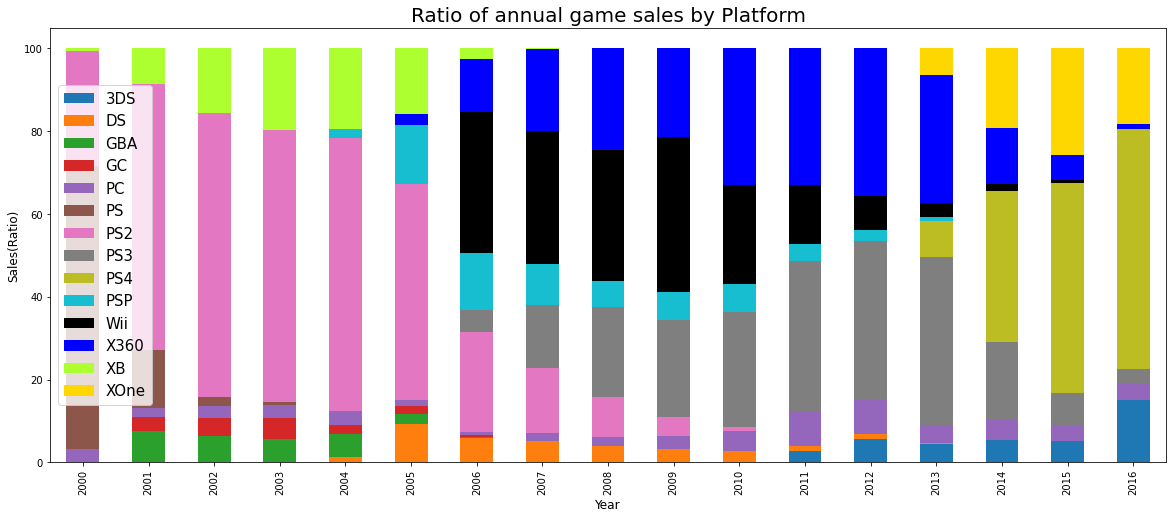

In [168]:
# 100% 기준의 누적 막대그래프 생성

df_plat['total'] = df_plat.apply(lambda row: 
                                 sum([row['3DS'], row['DS'], row['GBA'], row['GC'], row['PC'], row['PS'], row['PS2'], row['PS3'],
                                      row['PS4'], row['PSP'], row['Wii'], row['X360'], row['XB'], row['XOne']]), axis=1)
df_plat['3DS'] = df_plat['3DS'] / df_plat['total'] * 100
df_plat['DS'] = df_plat['DS'] / df_plat['total'] * 100
df_plat['GBA'] = df_plat['GBA'] / df_plat['total'] * 100
df_plat['GC'] = df_plat['GC'] / df_plat['total'] * 100
df_plat['PC'] = df_plat['PC'] / df_plat['total'] * 100
df_plat['PS'] = df_plat['PS'] / df_plat['total'] * 100
df_plat['PS2'] = df_plat['PS2'] / df_plat['total'] * 100
df_plat['PS3'] = df_plat['PS3'] / df_plat['total'] * 100
df_plat['PS4'] = df_plat['PS4'] / df_plat['total'] * 100
df_plat['PSP'] = df_plat['PSP'] / df_plat['total'] * 100
df_plat['Wii'] = df_plat['Wii'] / df_plat['total'] * 100
df_plat['X360'] = df_plat['X360'] / df_plat['total'] * 100
df_plat['XB'] = df_plat['XB'] / df_plat['total'] * 100
df_plat['XOne'] = df_plat['XOne'] / df_plat['total'] * 100

df_plat = df_plat.drop(['total'], axis=1)
df_plat

pyplot.rcParams['figure.figsize'] = [20, 8]

x = df_plat.index.values

df_plat.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))

pyplot.legend(loc='best', prop={'size': 15})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Ratio)', fontsize=12)
pyplot.title('Ratio of annual game sales by Platform', fontsize=20)


우선 플랫폼 별 연간 판매량에 대한 데이터를 누적 비율 막대그래프로 나타냈습니다.

2013년부터 2015년까지 3년동안 PS4와 Xbox One 그리고 3DS에 대한 점유율이 증가추세에 있습니다.

또한 플랫폼 별로 한 번 감소하기 시작한 판매량은 다시 늘지 않고 지속적으로 감소하는 경향을 보여주고 있습니다.

이를 바탕으로 **플랫폼 별 판매량은 기술 발전에 따른 불가역적인 트렌드로서**,

**게임 선정에 있어 임의로 취사 선택하기 어려운 외부 요인**으로 보아야 합니다.

따라서 점유율이 가장 높은 **PS4과 Xbox One 버전을  출시한 뒤에 3DS버전을 순차적으로 출시하는 일정**으로 진행하겠습니다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Text(0.5, 1.0, 'Total annual game sales by region')

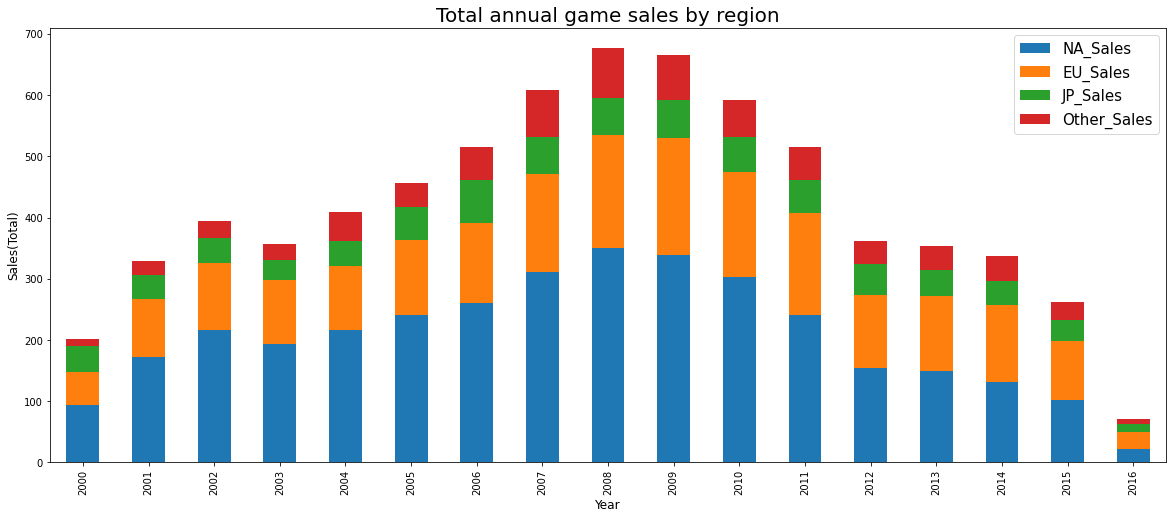

In [181]:
# 지역별 연간 총 판매량 그래프

from matplotlib import pyplot
import numpy as np

# 지역별 판매량 합계를 보여주는 데이터프레임 생성
df_region = df.groupby(['Year'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()
df_region = df_region.iloc[20:37]

# 지역별 연간 판매량을 보여주는 그래프 생성
pyplot.rcParams['figure.figsize'] = [20, 8]

x = df_region.index.values

df_region.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))

pyplot.legend(loc='best', prop={'size': 15})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Total)', fontsize=12)
pyplot.title('Total annual game sales by region', fontsize=20)

Text(0.5, 1.0, 'Ratio of annual game sales by region')

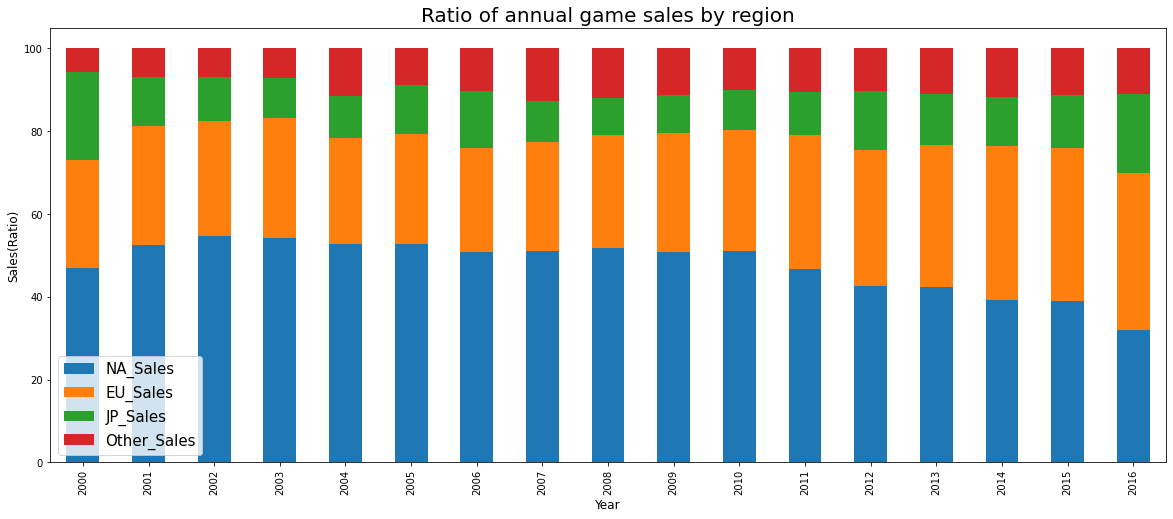

In [182]:
# 100% 기준의 누적 막대그래프 생성

df_region['total'] = df_region.apply(lambda row: sum([row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]), axis=1)
df_region['NA_Sales'] = df_region['NA_Sales'] / df_region['total'] * 100
df_region['EU_Sales'] = df_region['EU_Sales'] / df_region['total'] * 100
df_region['JP_Sales'] = df_region['JP_Sales'] / df_region['total'] * 100
df_region['Other_Sales'] = df_region['Other_Sales'] / df_region['total'] * 100
df_region = df_region.drop(['total'], axis=1)

pyplot.rcParams['figure.figsize'] = [20, 8]

x = df_region.index.values

df_region.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))

pyplot.legend(loc='best', prop={'size': 15})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Ratio)', fontsize=12)
pyplot.title('Ratio of annual game sales by region', fontsize=20)


지역별 판매량에 대한 누적 그래프 및 누적 비율 그래프를 나타내보았습나다.

판매량에 있어서 **유럽, 북미, 일본 시장 순으로 높은 판매량**을 보여주고 있으며,

이 **세 시장의 점유율은 90%**를 넘습니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Ratio of annual sales per game by region')

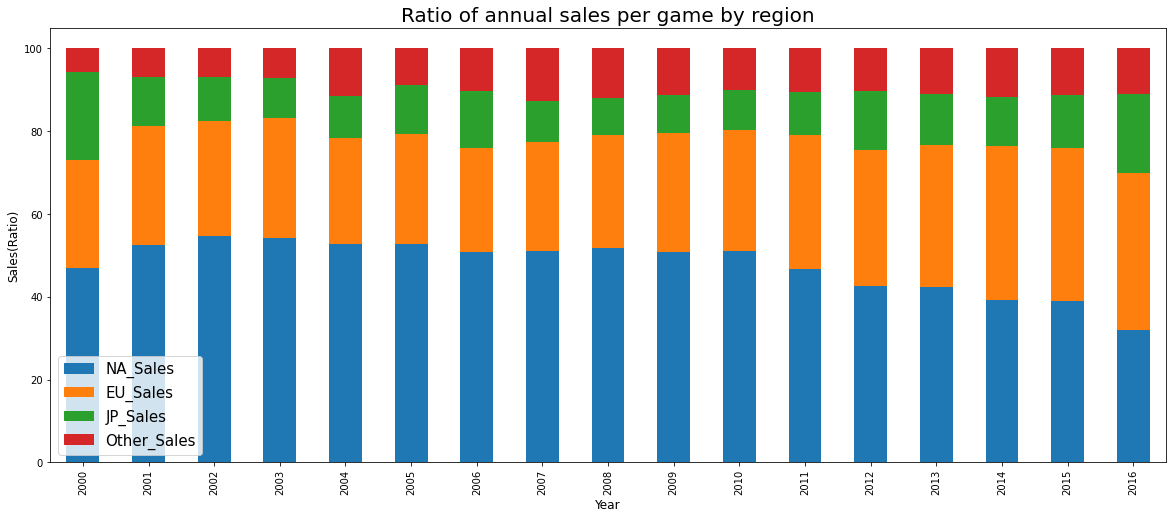

In [183]:
# 게임당 지역별 평균 매출액 누적 비율 그래프

df_region_per = df.groupby(['Year'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].mean()
df_region_per = df_region_per.iloc[20:37]
df_region_per['total'] = df_region_per.apply(lambda row: sum([row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]), axis=1)
df_region_per['NA_Sales'] = df_region_per['NA_Sales'] / df_region_per['total'] * 100
df_region_per['EU_Sales'] = df_region_per['EU_Sales'] / df_region_per['total'] * 100
df_region_per['JP_Sales'] = df_region_per['JP_Sales'] / df_region_per['total'] * 100
df_region_per['Other_Sales'] = df_region_per['Other_Sales'] / df_region_per['total'] * 100
df_region_per = df_region_per.drop(['total'], axis=1)


pyplot.rcParams['figure.figsize'] = [20, 8]

x = df_region_per.index.values

df_region_per.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))

pyplot.legend(loc='best', prop={'size': 15})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Ratio)', fontsize=12)
pyplot.title('Ratio of annual sales per game by region', fontsize=20)


지역별 출시 게임당 평균 판매량 또한 총 판매량과 유사한 점유율을 보이고 있습니다.

따라서 전체 시장 규모의 10% 이하인 **기타 시장은 타겟시장에서 제외**하도록 하겠습니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Text(0.5, 1.0, 'Total annual game sales by genre')

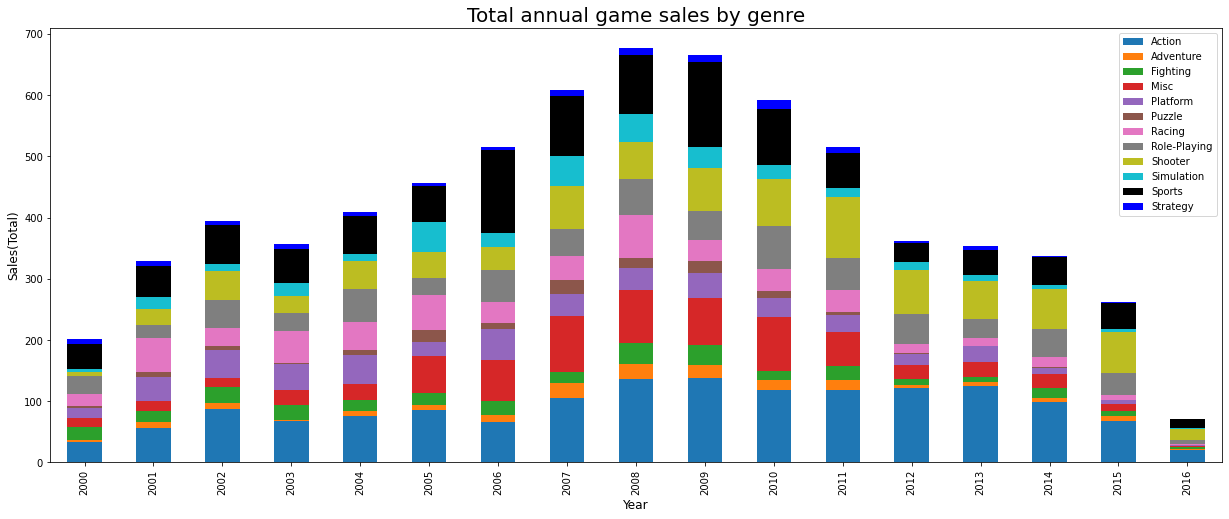

In [184]:
# 장르별 연간 판매량 그래프

from matplotlib import pyplot
import numpy as np

# 장르별 판매량 합계를 보여주는 데이터프레임 생성

df_genre = df.groupby(['Year','Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()
df_genre['total'] = df_genre.apply(lambda row: sum([row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]), axis=1)
df_genre = df_genre.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)
df_genre = df_genre.reset_index()
df_genre = df_genre.pivot(index='Year', columns='Genre', values='total')
df_genre = df_genre.fillna(0)
df_genre = df_genre.iloc[20:37]

# 장르별 연간 판매량을 보여주는 그래프 생성
pyplot.rcParams['figure.figsize'] = [21, 8]

x = df_genre.index.values

df_genre.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))


pyplot.legend(loc='best', prop={'size': 10})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Total)', fontsize=12)
pyplot.title('Total annual game sales by genre', fontsize=20)

Text(0.5, 1.0, 'Total annual game sales by genre')

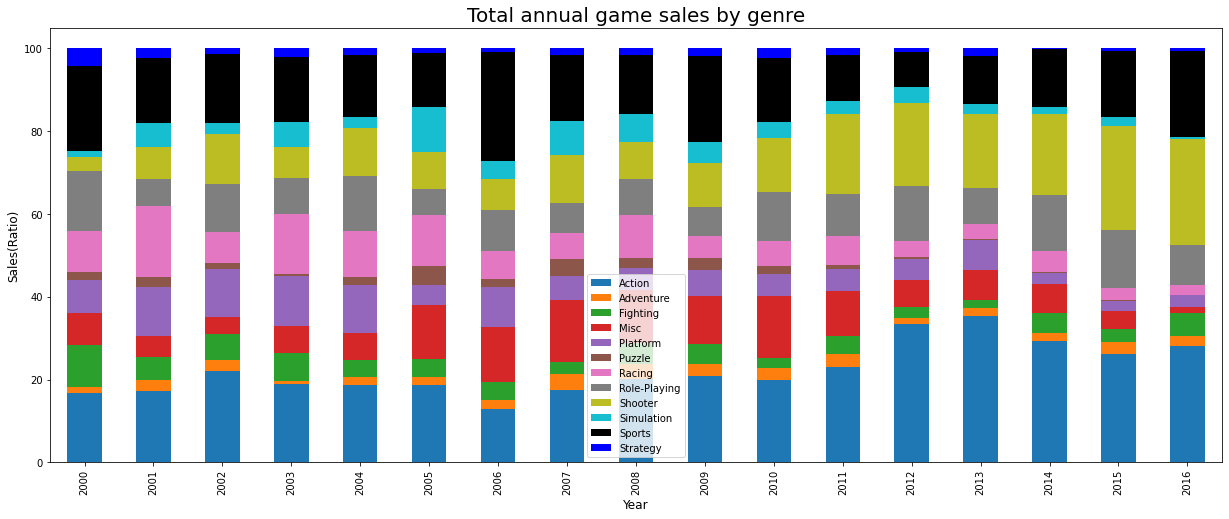

In [185]:
# 장르별 판매데이터를 백분율로 변경
df_genre['total'] = df_genre.apply(lambda row: sum([row['Action'], row['Adventure'], row['Fighting'], row['Misc'], row['Platform'], 
                                                    row['Puzzle'], row['Racing'], row['Role-Playing'], row['Shooter'], row['Simulation'], row['Sports'], row['Strategy']]), axis=1)
df_genre['Action'] = df_genre['Action'] / df_genre['total'] * 100
df_genre['Adventure'] = df_genre['Adventure'] / df_genre['total'] * 100
df_genre['Fighting'] = df_genre['Fighting'] / df_genre['total'] * 100
df_genre['Misc'] = df_genre['Misc'] / df_genre['total'] * 100
df_genre['Platform'] = df_genre['Platform'] / df_genre['total'] * 100
df_genre['Puzzle'] = df_genre['Puzzle'] / df_genre['total'] * 100
df_genre['Racing'] = df_genre['Racing'] / df_genre['total'] * 100
df_genre['Role-Playing'] = df_genre['Role-Playing'] / df_genre['total'] * 100
df_genre['Shooter'] = df_genre['Shooter'] / df_genre['total'] * 100
df_genre['Simulation'] = df_genre['Simulation'] / df_genre['total'] * 100
df_genre['Sports'] = df_genre['Sports'] / df_genre['total'] * 100
df_genre['Strategy'] = df_genre['Strategy'] / df_genre['total'] * 100
df_genre = df_genre.drop(['total'], axis=1)
df_genre

# 장르별 연간 판매량을 보여주는 그래프 생성
pyplot.rcParams['figure.figsize'] = [21, 8]

x = df_genre.index.values

df_genre.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))


pyplot.legend(loc='best', prop={'size': 10})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Ratio)', fontsize=12)
pyplot.title('Total annual game sales by genre', fontsize=20)


장르별 연간 총 판매량에 있어서는 **Shooter, Sports, Role-playing, Action** 게임이 높은 판매 비중을 보이고 있습니다.




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Total annual sales per game by genre')

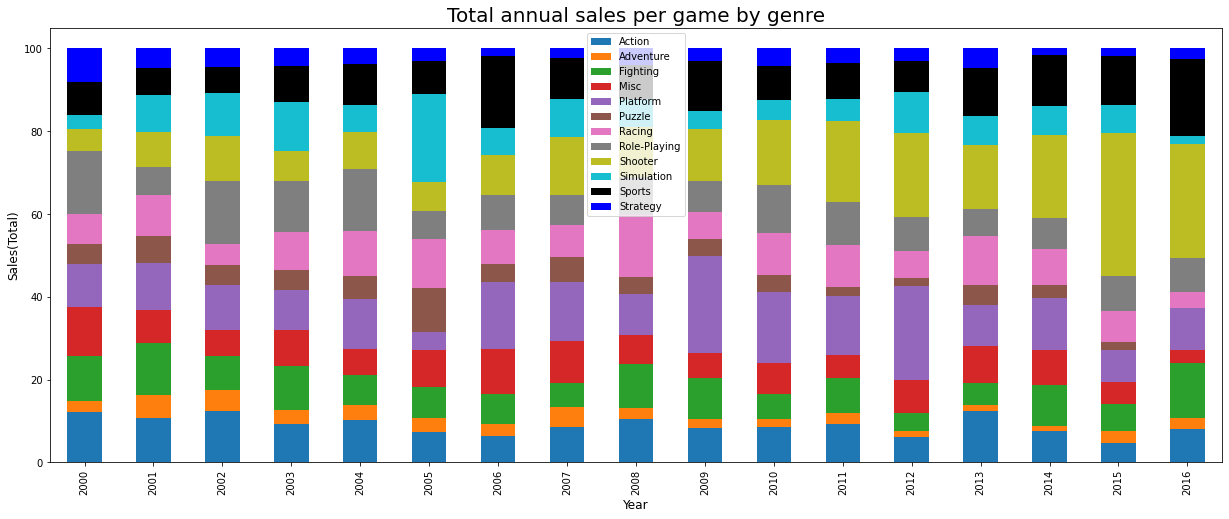

In [80]:
# 장르별 게임당 평균 판매량을 나타내는 데이터프레임 생성

df_genre_per = df.groupby(['Year','Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].mean()
df_genre_per['total'] = df_genre_per.apply(lambda row: sum([row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]), axis=1)
df_genre_per = df_genre_per.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)
df_genre_per = df_genre_per.reset_index()
df_genre_per = df_genre_per.pivot(index='Year', columns='Genre', values='total')
df_genre_per = df_genre_per.fillna(0)
df_genre_per = df_genre_per.iloc[20:37]

# 장르별 게임당 판매데이터를 백분율로 변경
df_genre_per['total'] = df_genre_per.apply(lambda row: sum([row['Action'], row['Adventure'], row['Fighting'], row['Misc'], row['Platform'], 
                                                    row['Puzzle'], row['Racing'], row['Role-Playing'], row['Shooter'], row['Simulation'], row['Sports'], row['Strategy']]), axis=1)
df_genre_per['Action'] = df_genre_per['Action'] / df_genre_per['total'] * 100
df_genre_per['Adventure'] = df_genre_per['Adventure'] / df_genre_per['total'] * 100
df_genre_per['Fighting'] = df_genre_per['Fighting'] / df_genre_per['total'] * 100
df_genre_per['Misc'] = df_genre_per['Misc'] / df_genre_per['total'] * 100
df_genre_per['Platform'] = df_genre_per['Platform'] / df_genre_per['total'] * 100
df_genre_per['Puzzle'] = df_genre_per['Puzzle'] / df_genre_per['total'] * 100
df_genre_per['Racing'] = df_genre_per['Racing'] / df_genre_per['total'] * 100
df_genre_per['Role-Playing'] = df_genre_per['Role-Playing'] / df_genre_per['total'] * 100
df_genre_per['Shooter'] = df_genre_per['Shooter'] / df_genre_per['total'] * 100
df_genre_per['Simulation'] = df_genre_per['Simulation'] / df_genre_per['total'] * 100
df_genre_per['Sports'] = df_genre_per['Sports'] / df_genre_per['total'] * 100
df_genre_per['Strategy'] = df_genre_per['Strategy'] / df_genre_per['total'] * 100
df_genre_per = df_genre_per.drop(['total'], axis=1)
df_genre_per

# 장르별 게임당 연간 판매량을 보여주는 그래프 생성
pyplot.rcParams['figure.figsize'] = [21, 8]

x = df_genre.index.values

df_genre_per.plot.bar(stacked=True, color=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'))


pyplot.legend(loc='best', prop={'size': 10})
pyplot.xlabel('Year', fontsize=12)
pyplot.ylabel('Sales(Total)', fontsize=12)
pyplot.title('Total annual sales per game by genre', fontsize=20)

장르별 연간 평균 판매량에 있어서는 **Shooter, Sports, Fighting, Platform, Role-playing, Action** 게임이 높은 판매 비중을 보이고 있습니다.



In [112]:
# 장르별 총 판매량
df_genre_sales = df.groupby(['Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales'].sum()

# 장르별 평균 판매량
df_genre_sales[['NA_Sales_per', 'EU_Sales_per', 'JP_Sales_per']] = df.groupby(['Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales'].mean()

# 장르별 판매량 표준편차
df_genre_sales[['NA_Sales_std', 'EU_Sales_std', 'JP_Sales_std']] = df.groupby(['Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales'].std()

# 순서정렬
df_genre_sales = df_genre_sales.sort_values(by='NA_Sales', axis=0, ascending=False)

df_genre_sales 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,NA_Sales,EU_Sales,JP_Sales,NA_Sales_per,EU_Sales_per,JP_Sales_per,NA_Sales_std,EU_Sales_std,JP_Sales_std
Genre,,,,,,,,,
Action,858.75,513.64,156.60,0.265046,0.158531,0.048333,0.571083,0.410886,0.164892
Sports,667.26,370.97,134.76,0.290239,0.161361,0.058617,1.047689,0.783081,0.225733
Shooter,574.48,310.23,38.18,0.448812,0.242367,0.029828,1.212672,0.554307,0.103505
Platform,445.38,200.63,130.53,0.510172,0.229817,0.149519,1.512274,0.592370,0.528878
Misc,394.73,208.15,104.18,0.234819,0.123825,0.061975,0.698647,0.445980,0.241776
Racing,354.70,235.02,56.32,0.290976,0.192797,0.046202,0.750121,0.587499,0.269769
Role-Playing,318.76,183.09,342.93,0.217584,0.124976,0.234082,0.663633,0.481635,0.640747
Fighting,220.35,99.90,87.14,0.263892,0.119641,0.104359,0.517588,0.252813,0.260628
Simulation,181.43,112.99,63.54,0.214456,0.133558,0.075106,0.471814,0.520098,0.306947



출시 장르를 확정하기 위해, 장르에 따른 지역별 판매량에 대한 분석을 진행하겠습니다.

현재 3개 시장의 데이터를 분석해야 하기 때문에 해석에 어려움이 있습니다.

따라서 **3차원의 데이터를 2차원이 데이터로 줄여** 분석을 보다 편리하게 진행하도록 하겠습니다.


In [113]:
# 미국시장과 유럽시장의 판매량 상관계수
df_2 = df[['NA_Sales', 'EU_Sales']]
df_corr_2 = df_2.corr(method = 'pearson')
display(df_corr_2)

# 미국시장과 일본시장의 판매량 상관계수
df_3 = df[['NA_Sales', 'JP_Sales']]
df_corr_3 = df_3.corr(method = 'pearson')
display(df_corr_3)

# 유럽시장과 일본시장의 판매량 상관계수
df_4 = df[['EU_Sales', 'JP_Sales']]
df_corr_4 = df_4.corr(method = 'pearson')
display(df_corr_4)

,NA_Sales,EU_Sales
NA_Sales,1.000000,0.768906
EU_Sales,0.768906,1.000000


,NA_Sales,JP_Sales
NA_Sales,1.000000,0.449358
JP_Sales,0.449358,1.000000


,EU_Sales,JP_Sales
EU_Sales,1.00000,0.43235
JP_Sales,0.43235,1.00000




장르에 따른 게임 판매량에 대해 지역별 상관관계 분석을 진행해보니 **북미시장의 판매량과 유럽시장의 판매량의 상관계수가 0.77 수준으로  강한 양의 상관관계**를 보이고 있음을 알 수 있습니다.

이는 유럽과 북미시장 둘 중 한곳의 시장에서 좋은 반응을 보일경우 다른 시장에서도 좋은 반응을 얻었다는 것입니다.

따라서 북미시장과 유럽시장을 하나의 특성으로 묶어서 분석을 진행하겠습니다.

단, 북미/유럽 시장과 일본 시장의 판매량에 대한 Scale 차이가 있기 때문에 지금부터는 데이터를 정규화 한 뒤에 분석을 진행하겠습니다.


In [114]:
# 북미시장과 유럽시장을 하나의 특성으로 묶을 목적으로 PCA 분석 진행

df_NA_EU = df[['NA_Sales', 'EU_Sales']]

# array 형태로 변경
x = df_NA_EU.values

# 변수간 스케일을 맞추기 위해 정규화 진행
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

# PCA 분석 진행
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
PC = pca.fit_transform(x)
NA_EU_Sales = pd.DataFrame(data = PC, columns = ['NA_EU_Sales'])
display(NA_EU_Sales.head())
NA_EU_Sales.shape

,NA_EU_Sales
0,-0.398635
1,-0.286861
2,-0.433027
3,-0.398635
4,-0.204656


(16241, 1)

In [115]:
# 일본시장에 대한 정규화 진행

df_JP = df[['JP_Sales']]

# array 형태로 변경
y = df_JP.values

# 변수간 스케일을 맞추기 위해 정규화 진행
from sklearn.preprocessing import StandardScaler
y = StandardScaler().fit_transform(y)
df_JP = pd.DataFrame(data = y, columns = ['JP_Sales'])
display(df_JP.head())
df_JP.shape

,JP_Sales
0,-0.253127
1,-0.253127
2,-0.188457
3,-0.253127
4,-0.253127


(16241, 1)

In [116]:
# 북미&유럽시장과 일본시장에서의 평균 판매량 및 표준편차에 대한 표준화 데이터 테이블 생성
df_sales_plot = pd.concat([NA_EU_Sales, df_JP], axis=1)
df_sales_plot = pd.concat([df_sales_plot, df['Genre']], axis = 1)
display(df_sales_plot.head())
df_sales_plot.shape

# 북미&유럽 시장과 일본 시장의 판매량 상관계수
df_5 = df_sales_plot[['NA_EU_Sales', 'JP_Sales']]
df_corr_5 = df_5.corr(method = 'pearson')
display(df_corr_5)

,NA_EU_Sales,JP_Sales,Genre
0,-0.398635,-0.253127,Action
1,-0.286861,-0.253127,Action
2,-0.433027,-0.188457,Adventure
3,-0.398635,-0.253127,Misc
4,-0.204656,-0.253127,Platform


,NA_EU_Sales,JP_Sales
NA_EU_Sales,1.000000,0.468767
JP_Sales,0.468767,1.000000



북미/유럽 시장의 데이터와 일본 시장의 데이터에 대한 장르별 상관관계 분석을 진행했습니다.

***상관계수가 약 0.47로 양의 상관관계***를 보이고 있으며, 장르를 확정하기 위해 이를 시각화하도록 하겠습니다.


In [119]:
from pandas import DataFrame

# 북미&유럽시장과 일본시장에서의 장르별로 그룹화된 평균 판매량 및 표준편차에 대한 표준화 데이터 테이블 생성
df_genre_std = df_sales_plot.groupby(['Genre'])['NA_EU_Sales', 'JP_Sales'].mean()
df_genre_std[['NA_EU_Sales_std', 'JP_Sales_std']] = df_sales_plot.groupby(['Genre'])['NA_EU_Sales', 'JP_Sales'].std()
display(df_genre_std)



corr_NAEU_JP = lambda g: g['NA_EU_Sales'].corr(g['JP_Sales'])
grouped = df_sales_plot.groupby('Genre')
DataFrame(grouped.apply(corr_NAEU_JP))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,NA_EU_Sales,JP_Sales,NA_EU_Sales_std,JP_Sales_std
Genre,,,,
Action,0.015386,-0.096841,1.008699,0.533179
Adventure,-0.294168,-0.120855,0.441824,0.390577
Fighting,-0.039705,0.084318,0.758336,0.842741
Misc,-0.058882,-0.052731,1.156369,0.781782
Platform,0.325308,0.230342,2.017268,1.710125
Puzzle,-0.124297,0.068166,1.199575,1.192846
Racing,0.085347,-0.103734,1.417551,0.872298
Role-Playing,-0.072099,0.503777,1.200821,2.071855
Shooter,0.290009,-0.156678,1.662664,0.334684


,0
Genre,
Action,0.292603
Adventure,0.401516
Fighting,0.461308
Misc,0.396672
Platform,0.836848
Puzzle,0.709812
Racing,0.745288
Role-Playing,0.629548
Shooter,0.286927


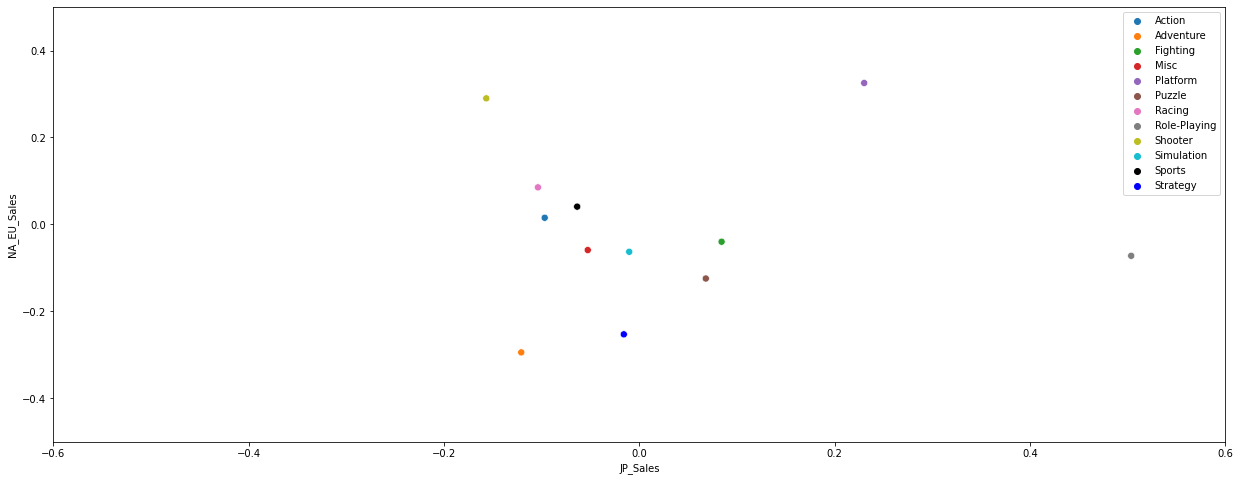

In [141]:
# 북미/유럽시장과 일본시장의 장르별 판매량에 대한 scatter plot

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='JP_Sales', 
                y='NA_EU_Sales', 
                hue='Genre', # different colors by group
                s=50, # marker size
                palette= ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'black', 'blue', 'greenyellow', 'gold'),
                data=df_genre_std)
plt.legend(loc='best')
#sns.regplot("JP_Sales", "NA_EU_Sales", data=df_genre_std, ci=None, scatter=False)
plt.ylim(-0.5, 0.5)
plt.xlim(-0.6, 0.6)

plt.show()


위의 그래프를 해석해보면, 

Shooter 장르의 경우 북미/유럽에서의 평균 판매량은 12개의 게임장르 중 두전째로 높지만 일본에서는 열두번째로 가장 낮습니다.

Role-playing 장르의 경우 일본에서의 평균 판매량은 첫번째로 높지만 북미/유럽에서의 판매량은 아홉번째로 낮은 편입니다.

Platform 장르의 경우 북미/유럽 시장에서의 평균 판매량이 첫번째로 높으며, 일본시장에서의 판매량 또한 두번째로 높습니다.



종합하여 말씀드리면 **유럽/북미/일본시장을 타겟**으로 **Platform** 장르의 게임을 출시해야 하며,

점유율이 가장 높은 **PS4와 Xone 버전**으로 먼저 출시 한 후에 **3DS 버전** 출시를 진행해야 합니다.

다만 **Platform 게임의 경우 타 장르에 비해 판매량에 대한 표준편차가 큰 편**입니다. ("df_genre_std" 데이터프레임 참조)

따라서 Platform 장르 중에 성공한 게임에 대한 충분한 케이스 스터디를 진행한 뒤에 게임 설계를 진행해야 할 것입니다. 

In [148]:
# 퍼블리셔별 지역별 판매량
df_pulisher = df.groupby(['Publisher'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()

# 순서정렬
df_pulisher = df_pulisher.sort_values(by='NA_Sales', axis=0, ascending=False)

df_pulisher

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Publisher,,,,
Nintendo,808.14,410.34,447.43,93.67
Electronic Arts,579.90,366.11,13.98,127.19
Activision,425.10,213.17,6.54,74.55
Sony Computer Entertainment,263.70,186.74,73.72,79.42
Ubisoft,252.26,162.99,7.33,50.12
...,...,...,...,...
New,0.00,0.00,0.33,0.02
Societa,0.00,0.00,0.04,0.00
NetRevo,0.00,0.00,0.03,0.00
